## Project 3: Non Linear Programming

Team:

Jesper Li(jjl3928)

Yashpreet Kaur(yk8742)

Surya Prasad Reddy(sp49882)
    

In [21]:
import numpy as np
import pandas as pd
import gurobipy as gp
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LassoCV, Lasso
from sklearn.model_selection import KFold
%matplotlib inline

In [2]:
timelimit=3600

## Data Preprocessing

In [3]:
# Loading the training data into dataframe
X_train = pd.read_csv('training_data.csv')
y_train=X_train.iloc[:,0]
X_train.iloc[:,0]=1
X_train = X_train.rename({'y': 'X0'}, axis=1)

# Loading the test data into dataframe
X_test = pd.read_csv('test_data.csv')
y_test=X_test.iloc[:,0]
X_test.iloc[:,0]=1
X_test = X_test.rename({'y': 'X0'}, axis=1)

## Direct Variable Selection: MIQP

Objective function: $ x^{T}Qx + c^{T}x $<br>
s.t.<br> 
$ Ax  \le b $<br>
$ x  \ge 0 $



Lasso Regression:

Decision Variables:
1. $ \beta_{0}, \beta_{1} ... \beta_{m}$ - Coefficients - (m+1)
2. $ z_{1}, z_{2} ... z_{m}$ - Decison to keep the variable to drop it from regression - (m) <br>

Constraints:
1. Coefs ($\beta_{i}$) shoud be within a given range ($|M|$) and should be non-zero iff $z_{i} > 0$ - (2m)
2. Total number of coefs in final model should be less than k - (1) <br>

Total Constraint equations - 2m +1

Objective function for lasso: $$ \beta^{T}(X^{T}X)\beta + (-2y^{T}X)\beta$$<br>
s.t.<br> 
$$ -z_{i}M < \beta_{i} < z_{i}M $$   for i=1,2...m<br>
$$ \sum_{i=1}^m z_{i} \le k $$


$ Q =(X^{T}X) $<br>
$ c =(-2y^{T}X) $

In [4]:

# the function will perform MIQP direct variable selection on training data
# it returns the sum of squared errors of the test data based on the trianinng model 
# It returns the preicted values of test data if send_pred is set to 1


def MIQP(k,train_x,test_x, train_y,test_y,send_pred):
    
    # Big M is set to 20
    
    M=20
    
    # The size of features and training data set
    m=train_x.shape[1]-1
    n=train_x.shape[0]
    X=train_x.to_numpy()
    
    # Creating Q matrix
    Q=np.zeros((2*m+1,2*m+1))
    Q[:m+1,:m+1] = X.T @ X
    
    # Creating C matric
    
    C=np.zeros((2*m+1))
    C[:m+1]=-2*(train_y.to_numpy()).T@X
    
    # Creating constraint matrix
    A=np.zeros((2*m+1,2*m+1))
    b=np.zeros((2*m+1,1))
    
    for i in range(m):
        A[i,i+1]=1
        A[i,i+1+m]=M
        
    for i in range(m):
        A[m+i,i+1]=1
        A[m+i,i+1+m]=-1*M
    
    for i in range(m+1,2*m+1):
        A[2*m,i]=1
    b[2*m]=k
    
    sense=['>']*m+['<']*(m+1)
    
    # setting variable types
    vtype=['C']*(m+1)+['B']*m
    
    # setting lower bounds on the coefficients
    lb=[-1*M]*(m+1)+[0]*m
    
    # Initialising the model and optimising using gurobi
    model = gp.Model()
    modelX = model.addMVar(2*m+1, lb=lb, ub=None, vtype=vtype)
    modelConstr = model.addMConstr(A, modelX, sense, b)
    model.setMObjective(Q,C,0, sense = gp.GRB.MINIMIZE)
    model.Params.OutputFlag = 0
    model.Params.timeLimit = timelimit
    model.optimize()
    
    # checking if the coefficients did not breach the big M
    coef=modelX.x[:m+1]
    for beta in coef:
        if beta==M or beta ==-1*M:
            print("coeff bounded")
    
    #returns sum of squared errors based on the test data predictions
    if send_pred==0:
        return (test_y- test_x @ modelX.x[:m+1]).T@(test_y- test_x @ modelX.x[:m+1])
    else:
        return (test_y- test_x @ modelX.x[:m+1]).T@(test_y- test_x @ modelX.x[:m+1]), (test_x @ modelX.x[:m+1]),modelX.x[:m+1]
        
    
    
    
    

In [5]:
# all the possible values of k from 5 to 50
params_rows=[5*i for i in range(1,11)]

# the 10 fold cross validation results
params_cols=[i for i in range(1,11)]

df=pd.DataFrame(index=params_rows,columns=params_cols)

i=0
for k in params_rows:
    cvnum=0
    print(k)
    
    #10 fold cross validation on K
    kf = KFold(10, shuffle=False)#, random_state=1)
    
    for train_index, test_index in kf.split(X_train):
        train_x, test_x = X_train.iloc[train_index,:], X_train.iloc[test_index,:] 
        train_y, test_y = y_train[train_index], y_train[test_index]
        
        # storing the values of each cross validation for each value of K in df dataframe
        df.iloc[i,cvnum]=MIQP(k,train_x,test_x,train_y,test_y,0)
        cvnum+=1
    i+=1 


5
Set parameter Username
Academic license - for non-commercial use only - expires 2022-09-15
10
15
20
25
30
35
40
45
50


In [6]:
val_sse = df.sum(axis=1)
print('Best Value of K and SSE is ',val_sse[val_sse == val_sse.min()])

Best Value of K and SSE is  10    724.787631
dtype: float64


## Cross Validation error(Sum of Squared errors) as function of K

In [7]:
val_sse = pd.DataFrame(data=val_sse,columns=["SSE"])
val_sse

,SSE
5,917.479061
10,724.787631
15,764.049938
20,799.012201
25,770.482828
30,830.082402
35,831.104008
40,847.622598
45,843.642637
50,847.184545


## Plot Cross validation error as function of K

Text(0.5, 1.0, 'Cross Validation error as function of K')

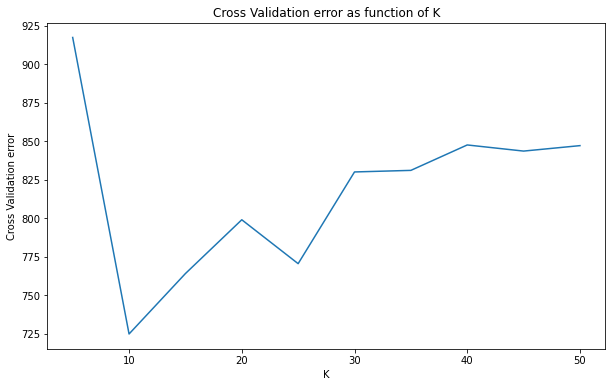

In [8]:
plt.figure(figsize=(10, 6))
plt.plot(params_rows, val_sse)
plt.xlabel("K")
plt.ylabel("Cross Validation error")
plt.title("Cross Validation error as function of K")

In [9]:
df.to_csv('out1.csv')

## Direction selction MIQP on the best value of K 

In [10]:
err, y_pred_miqp,coef_miqp=MIQP(10,X_train,X_test,y_train,y_test,1)
print("The SSE error on the test data for the best value of K:10 is ", err)

The SSE error on the test data for the best value of K:10 is  116.8271982276263


## Indirect Variable Selection Lasso Regression
The Lasso Regression problem is formulated as:

$$ \underset{\beta,z}min\sum_{i=1}^n (\beta_0 + \beta_1x_{i1} + ... + \beta_mx_{im} - y_i)^2 + \lambda\sum_{j=1}^m|\beta_j| $$

In [24]:
# 10 fold cross calidation on the indirect lasso regression
cross_val = KFold(n_splits=10, shuffle=False)

# fitting the model
lasso_regression = LassoCV(cv = cross_val).fit(X_train,y_train)
alpha=lasso_regression.alpha_

#Lasso regression with best value of alpha

lasso_regression = Lasso(alpha=alpha)
lasso_regression.fit(X_train,y_train)

# Number of Non zero coefficients
print('Non-zero Coefficients of Lasso Regression ',   sum(lasso_regression.coef_ != 0))

# Predicting the values of test data
y_pred = lasso_regression.predict(X_test)
err_lasso_reg=(y_test-y_pred).T@(y_test-y_pred)
print("The SSE on test data for Indirect Lasso Regression with best aplha " +str(alpha) + "  is  " +str(err_lasso_reg))


Non-zero Coefficients of Lasso Regression  17
The SSE on test data for Indirect Lasso Regression with best aplha 0.07638765995113507  is  117.48173795802897


## Comparison of the Models

## Comparison of predicted values of test data of MIQP and indirect Lasso with actual data

In [26]:
preds = pd.DataFrame(columns=["y_actual","y_pred_miqp","y_pred_lasso"])
preds["y_actual"]=y_test
preds["y_pred_miqp"]=y_pred_miqp
preds["y_pred_lasso"]=y_pred
preds.head()

,y_actual,y_pred_miqp,y_pred_lasso
0,7.107949,6.179859,6.076864
1,5.796272,5.095243,4.918107
2,1.598651,3.285595,3.227780
3,2.532953,3.758485,3.571386
4,0.590685,-0.332975,-0.418499


## Plot of predictions of MIQP and Indirect Lasso

Text(0.5, 1.0, 'Comparison of predictions of MIQP and Indirect Lasso with test data')

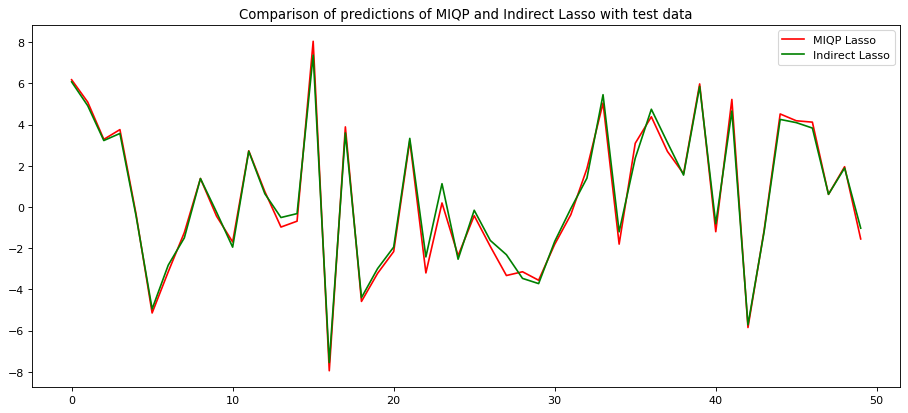

In [13]:
idx=[i for i in range(y_test.shape[0])]
plt.figure(figsize=(14, 6), dpi=80)
plt.plot(idx, y_pred_miqp, color='r', label='MIQP Lasso')
plt.plot(idx, y_pred, color='g', label='Indirect Lasso')
#plt.plot(idx, y_test, color='b', label='Actual data')
plt.legend()
plt.title("Comparison of predictions of MIQP and Indirect Lasso with test data")


## Comparison of Coefficients of MIQP and indirect Lasso

In [14]:
coefs = pd.DataFrame(columns=["coef_miqp","coef_lasso"])
coefs["coef_miqp"]=coef_miqp
coefs["coef_lasso"]=lasso_regression.coef_
coefs.head()

,coef_miqp,coef_lasso
0,0.972524,0.0
1,0.000000,-0.0
2,0.000000,-0.0
3,0.000000,0.0
4,0.000000,0.0


## Plot of Coefficients of MIQP and indirect Lasso

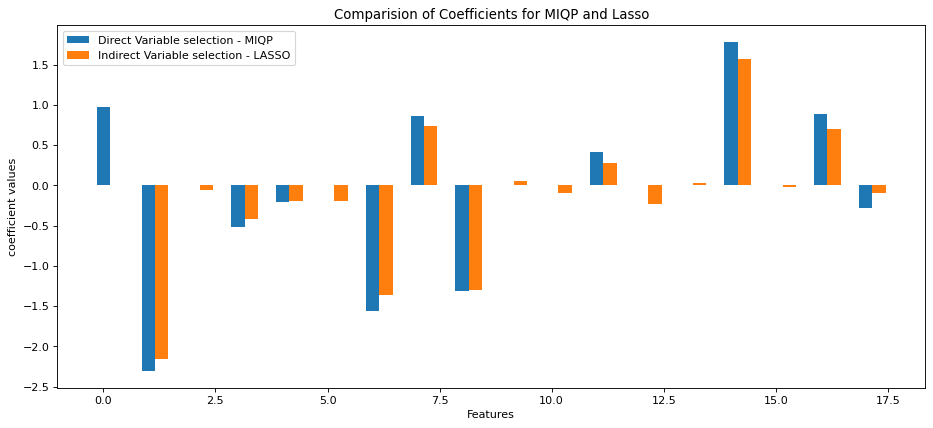

In [15]:
plt.figure(figsize=(14, 6), dpi=80)
coefs = coefs[(coefs['coef_miqp'] != 0) | (coefs['coef_lasso'] != 0)]

width = 0.3
ind = np.arange(len(coefs))
index=[i for i in range(51)]
#plt.xticks(ind + width / 2,index )
plt.bar(ind, coefs['coef_miqp'], label='Direct Variable selection - MIQP', width=width)
plt.bar(ind + width, coefs['coef_lasso'], label='Indirect Variable selection - LASSO', width=width)

plt.xlabel('Features')
plt.ylabel('coefficient values')
plt.title('Comparision of Coefficients for MIQP and Lasso')
plt.legend()
plt.show()